In [43]:
import pandas as pd
from pytz import country_timezones
import time
import numpy as np
import timezonefinder
from datetime import datetime as dt
import pytz
import calendar
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams

In [2]:
data = pd.read_csv("C:/Users/fabri/OneDrive/Desktop/GIT/Data_Management_Project/Csv/Exported_queries/mtime.csv") #import dataset
data.head() #check

,mtime,group_country,group_state,long,lat
0,1545782699258,us,FL,-80.15,26.02
1,1545827677229,us,PA,-75.20,39.96
2,1545785377241,nz,NONE,174.78,-41.28
3,1545780008634,us,NY,-73.38,40.69
4,1545770541536,us,TX,-106.49,31.76


In [3]:
data.group_state = data.group_state.str.lower() #lower case for group_state
data.head() #check

,mtime,group_country,group_state,long,lat
0,1545782699258,us,fl,-80.15,26.02
1,1545827677229,us,pa,-75.20,39.96
2,1545785377241,nz,none,174.78,-41.28
3,1545780008634,us,ny,-73.38,40.69
4,1545770541536,us,tx,-106.49,31.76


In [4]:
tf = timezonefinder.TimezoneFinder() #defining time zones on lat, long data
data['timezone_str'] = "nan"
count = 0
start = time.time()
for line in data.itertuples():
    count+=1
    try:
        data.timezone_str.at[line.Index] = tf.timezone_at(lat = data.iloc[line.Index]['lat'],
                                                          lng = data.iloc[line.Index]['long'])
    except Exception as e:
        print(e)
        break
    #if count == 10:
        #break
end = time.time()
print("task completed in "+str((end-start)/60)+" minutes")

task completed in 19.190913625558217 minutes


In [5]:
data.head() #check

,mtime,group_country,group_state,long,lat,timezone_str
0,1545782699258,us,fl,-80.15,26.02,America/New_York
1,1545827677229,us,pa,-75.20,39.96,America/New_York
2,1545785377241,nz,none,174.78,-41.28,Pacific/Auckland
3,1545780008634,us,ny,-73.38,40.69,America/New_York
4,1545770541536,us,tx,-106.49,31.76,America/Denver


In [6]:
data.any().isnull() #check

mtime            False
group_country    False
group_state      False
long             False
lat              False
timezone_str     False
dtype: bool

In [7]:
data1 = data[data.lat != 0.0] #cleaned dataset
data1[data1.lat == 0] #check

,mtime,group_country,group_state,long,lat,timezone_str


In [8]:
data1.any().isnull() #another check, no more missing values

mtime            False
group_country    False
group_state      False
long             False
lat              False
timezone_str     False
dtype: bool

In [9]:
def rounder(t): #this function round the time to nearest hour
    if t.minute >= 30:
        if t.hour == 23:
            return t.replace(second=0, microsecond=0, minute=0, hour=0)
        else:
            return t.replace(second=0, microsecond=0, minute=0, hour= t.hour+1)
    else:
        return t.replace(second=0, microsecond=0, minute=0)

In [10]:
#data1['datetime_timezoned'] = "nan" #this method create problems with "SettingWithCopyWarning" don't know why
data1 = data1.assign(datetime_timezoned = "") #defining new column converting timestamp into datetime conditionally to time zones
start = time.time()
count = 0
for line in data1.itertuples():
    count+=1
    try: #this first line is to eventually create a column with the original UTC datetime format
        #data1.loc[line.Index, 'datetime'] = dt.fromtimestamp(timestamp = (data1.loc[line.Index, 'mtime'])/1000)
        data1.datetime_timezoned.at[line.Index] = rounder((dt.fromtimestamp
                                                   (timestamp = (data1.loc[line.Index, 'mtime'])/1000,
                                                    tz = pytz.timezone(data1.loc[line.Index, 'timezone_str'])
                                                   ))).strftime("%d/%m/%Y %H:%M:%S")
        #data1.datetime_timezoned.at[line.Index] = data1.iloc[line.Index]['datetime_timezoned'].strftime("%d/%m/%Y %H:%M:%S")
        #these two lines create first of all a column with the datetime timezoned based on the time zone of the group that
        #host the event, and in second time they change the format of that datetime
    except Exception as e:
        print(e)
        break
    #if count == 100:
        #break
end = time.time()
print('task completed in '+str((end-start)/60)+' minutes')

task completed in 4.672426859537761 minutes


In [11]:
data1.head()

,mtime,group_country,group_state,long,lat,timezone_str,datetime_timezoned
0,1545782699258,us,fl,-80.15,26.02,America/New_York,25/12/2018 19:00:00
1,1545827677229,us,pa,-75.20,39.96,America/New_York,26/12/2018 08:00:00
2,1545785377241,nz,none,174.78,-41.28,Pacific/Auckland,26/12/2018 14:00:00
3,1545780008634,us,ny,-73.38,40.69,America/New_York,25/12/2018 18:00:00
4,1545770541536,us,tx,-106.49,31.76,America/Denver,25/12/2018 14:00:00


In [ ]:
#this code use a list to create the datetime_timezoned column, more efficient, 1 minute less than the other method
'''
datetime_timezoned = []
start = time.time()
count = 0
for line in data1.itertuples():
    count+=1
    try: #this first line is to eventually create a column with the original UTC datetime format
        #data1.loc[line.Index, 'datetime'] = dt.fromtimestamp(timestamp = (data1.loc[line.Index, 'mtime'])/1000)
        datetime_timezoned.append((dt.fromtimestamp(timestamp = (data1.loc[line.Index, 'mtime'])/1000,
                                                    tz = pytz.timezone(data1.loc[line.Index, 'timezone_str'])
                                                   )).strftime("%d/%m/%Y %H:%M:%S"))
        #data1.datetime_timezoned.at[line.Index] = data1.iloc[line.Index]['datetime_timezoned'].strftime("%d/%m/%Y %H:%M:%S")
        #these two lines create first of all a column with the datetime timezoned based on the time zone of the group that
        #host the event, and in second time they change the format of that datetime
    except Exception as e:
        print(e)
        break
    #if count == 10000:
        #break
data1['datetime_timezoned'] = datetime_timezoned
end = time.time()
print('task completed in '+str((end-start)/60)+' minutes')
'''

In [12]:
new = data1['datetime_timezoned'].str.split(" ", n = 1, expand = True) #create distinct columns date and time
data1['date'] = [calendar.day_name[dt.strptime(date, '%d/%m/%Y').weekday()] for date in new[0]] #transform date into weekdays
data1['time'] = new[1] #take time

In [13]:
data1.head() #check

,mtime,group_country,group_state,long,lat,timezone_str,datetime_timezoned,date,time
0,1545782699258,us,fl,-80.15,26.02,America/New_York,25/12/2018 19:00:00,Tuesday,19:00:00
1,1545827677229,us,pa,-75.20,39.96,America/New_York,26/12/2018 08:00:00,Wednesday,08:00:00
2,1545785377241,nz,none,174.78,-41.28,Pacific/Auckland,26/12/2018 14:00:00,Wednesday,14:00:00
3,1545780008634,us,ny,-73.38,40.69,America/New_York,25/12/2018 18:00:00,Tuesday,18:00:00
4,1545770541536,us,tx,-106.49,31.76,America/Denver,25/12/2018 14:00:00,Tuesday,14:00:00


In [14]:
#writing the new csv
#data1.to_csv("C:/Users/fabri/OneDrive/Desktop/GIT/Data_Management_Project/Csv/Exported_queries/mtime_manipulated.csv")

In [37]:
#data2 = pd.read_csv("C:/Users/fabri/OneDrive/Desktop/GIT/Data_Management_Project/Csv/Exported_queries/mtime_manipulated.csv")
data2 = data1[['date','time']] #define new dataframe
data2.head() #check

,date,time
0,Tuesday,19:00:00
1,Wednesday,08:00:00
2,Wednesday,14:00:00
3,Tuesday,18:00:00
4,Tuesday,14:00:00


In [38]:
data2['date'] = pd.Categorical(data2['date'], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
#sorting the days of the week 
data2['values'] = 1 #create a column that represent the single instance
pivot_table = data2.pivot_table(values = 'values', index = 'date', columns = 'time', aggfunc = np.sum)
#using the representation of the value we can use np.sum to calculate the number of times a message is generated in a certain
#week's day, in a certain hour
pivot_table
#we can ignore this warning, it's caused by the creation of values' column, but being composed of only 1 this warning is useless

C:\Users\fabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\fabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
date,,,,,,,,,,,,,,,,,,,,,
Monday,1682,2228,1186,803,531,541,606,575,984,1557,...,1464,1222,1355,1059,932,642,318,165,118,79
Tuesday,2493,23,19,16,10,8,10,22,44,109,...,3484,4094,6061,6646,7169,7408,7411,8410,7781,6125
Wednesday,6422,2641,1573,1124,1046,1244,2339,4314,7592,11258,...,17451,17465,16891,16618,15081,14582,14902,16496,14950,11552
Thursday,8078,4696,2972,1865,1566,2085,3089,5594,8972,12821,...,18019,18471,18668,18821,17296,15557,16088,16996,15933,12503
Friday,8139,4873,3187,2088,1918,2249,4110,6647,10694,14498,...,18236,17717,17741,18623,17781,16639,15131,15225,14259,11586
Saturday,6130,5386,3117,2249,1638,1862,2868,4588,7631,9017,...,9477,7697,7609,7513,7065,6723,6502,6041,5677,4847
Sunday,3517,2459,1255,849,715,670,973,1761,3351,4811,...,6388,6035,6098,6363,6020,6141,6177,6083,5585,4997


In [44]:
rcParams['figure.figsize'] = 11.7,8.27 #define a parameter to change the figure size

[Text(84.3,0.5,'Weekdays'), Text(0.5,202.042,'Hours')]

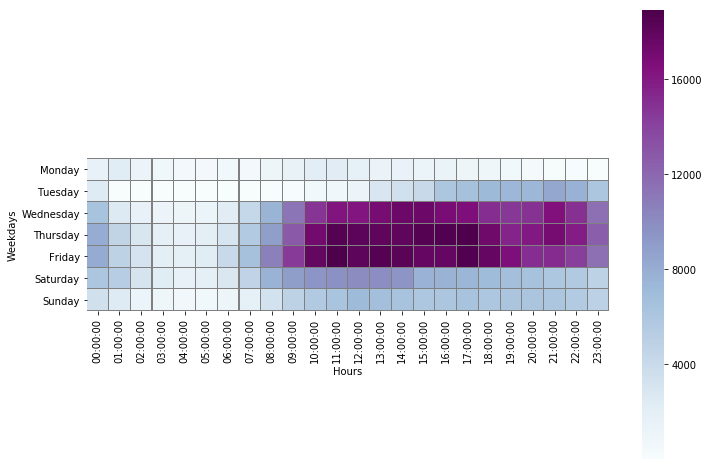

In [67]:
figure = sns.heatmap(pivot_table,cmap='BuPu',linecolor='grey',linewidths=.1, square = True) #define an heatmap to plot our pivot_table
figure.set(xlabel = "Hours", ylabel = "Weekdays")    

In [68]:
#to save the figure
#figure.figure.savefig("C:/Users/fabri/OneDrive/Desktop/heatmap.png")